In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urljoin
import re


base_url = "https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES"

# Get the main page listing all cities
response = requests.get(base_url)
soup = BeautifulSoup(response.content, 'html.parser')

# Extract city links
city_links = soup.find_all('a', href=True)  # Extracts all anchor tags with an href

# Filter for links that contain the "city" parameter
city_urls = []
for link in city_links:
    href = link['href']
    if 'city=' in href:  # Check if 'city=' is in the href attribute
        # Join with the base URL to handle any relative URLs
        full_url = urljoin(base_url, href)
        city_urls.append(full_url)

# Display or work with the list of city URLs
print(city_urls)


['https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=84iGWBpo', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=IT3H5sPq', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=HxJh6PWs', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=es_jmrl0woo', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=YzuNnRu5', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=6DV7CWcv', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=es_m70tybwl', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=RQoH6noz', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=xVNF4F90', 'https://mobilityweek.eu/participating-towns-and-cities/?year=2024&country=ES&city=E16Ss1bl', 'https://mobilityweek.eu/participating-towns-and-citi

In [ ]:
def extract_activities(city_url):
    # Ensure city_url is a valid string and not a tuple or other structure
    if not isinstance(city_url, str):
        raise ValueError("city_url should be a string")

    # Fetch the URL content
    response = requests.get(city_url)
    response.raise_for_status()  # Raise an error for bad responses (4xx or 5xx)

    # Parse the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract city name
    city_heading = soup.find("h1", id="participation_page_heading")
    city_name = city_heading.text.strip() if city_heading else "Unknown"
    
    # Extract population
    population_div = soup.find("div", class_="population city_data_row")
    population = None
    if population_div:
        population_text = population_div.find("div", class_="data").text.strip()
        population_match = re.search(r'\d[\d,.]*', population_text)
        if population_match:
            population = population_match.group().replace('.','').replace(',', '')
    
    # Extract coordinates (latitude and longitude)
    script_tag = soup.find("script", text=re.compile(r"googleMaps\(.+?\);"))
    latitude = longitude = None
    if script_tag:
        # Use regex to extract lat and lng from the script tag
        coordinates = re.search(r"googleMaps\(([\d.-]+),\s*([\d.-]+)", script_tag.string)
        if coordinates:
            latitude = float(coordinates.group(1))
            longitude = float(coordinates.group(2))
    
    # Extract activities
    activities = []
    activity_boxes = soup.find_all("div", class_="activity_details_box")
    
    for box in activity_boxes:
        name = box.find("div", class_="activity_name").text.strip() if box.find("div", class_="activity_name") else "Unnamed Activity"
        description_box = box.find("div", class_="activity_description")
        description = description_box.text.strip() if description_box else "No description available"
        
        # Append as dictionary to activities list
        activities.append({
            "name": name,
            "description": description
        })
    return {
        "city_name": city_name,
        "population": population,
        "latitude": latitude,
        "longitude": longitude,
        "activities": activities
    }
    

In [ ]:
data = []

# Iterate through city URLs and extract city name and activity details
for city_url in enumerate(city_urls[1:]):
    city_info = extract_activities(city_url[1])
    
    # For each activity, add a record to the data list
    for activity in city_info['activities']:
        data.append({
            "city": city_info['city_name'],
            "population": city_info['population'],
            "latitude": city_info['latitude'],
            "longitude": city_info['longitude'],
            "activity_name": activity['name'],
            "activity_description": activity['description']
        })

# Convert the list of dictionaries to a pandas DataFrame
df = pd.DataFrame(data)
df['ID'] = df.index
df.to_csv('./activities.csv')
# Show the DataFrame

pd.set_option('display.max_rows', 100)
display(df)

In [ ]:
df_city = df.drop(columns=['activity_name', 'activity_description'])
df_unique_cities = df_city.drop_duplicates()
df_unique_cities.to_csv('city_data.csv', index=False)
print(df_unique_cities)

In [ ]:
import pandas as pd
from googletrans import Translator
from tqdm import tqdm

# Initialize Google Translator
translator = Translator()

# Step 1: Load the CSV file
df = pd.read_csv('activities.csv')

# Step 2: Create a new column 'prompt' by translating 'activity_name' and 'activity_description'
prompts = []

# Use tqdm to visualize progress
for i, row in tqdm(df.iterrows(), total=len(df), desc="Translating and creating prompts"):
    try:
        # Translate 'activity_name' and 'activity_description' to English
        translated_name = translator.translate(row['activity_name'], dest='en').text
        translated_desc = translator.translate(row['activity_description'], dest='en').text

        # Combine them into the prompt
        prompt = (f"This is an event called '{translated_name}', part of a broader effort during Mobility Week "
                  f"to promote sustainable mobility by local governments. Its complete description is: '{translated_desc}'")
        prompts.append(prompt)

    except Exception as e:
        # If any translation fails, log the error and use the original text
        print(f"Error translating row {i}: {e}")
        prompts.append(
            f"This is an event called '{row['activity_name']}', part of a broader effort during Mobility Week "
            f"to promote sustainable mobility by local governments. Its complete description is: '{row['activity_description']}'")

# Step 3: Add the 'prompt' column to the DataFrame
df['prompt'] = prompts

# Step 4: Save the updated DataFrame to 'activities_t.csv'
df.to_csv('activities_t.csv', index=False)


In [2]:
import pandas as pd
from tqdm import tqdm
import logging
from transformers import pipeline

logging.basicConfig(level=logging.INFO)
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
# Primary classification categories (first level)
primary_category_dict = {
    "This activity is a cycling march or bicycle route, part of a broader effort to promote sustainable mobility and an active lifestyle.": 'Cycling Event',
    "This activity is a walking tour, guided tour, or organized walk": 'Walking Tour',
    "This activity is a road safety course, driving workshop or road safety conference. It aims to educate participants on traffic safety and improve their driving or cycling skills.": 'Road Safety Workshop',
    "This activity is a Car-Free Day event that involves traffic closures or restrictions to promote the use of sustainable mobility options": 'Car-Free Day',
    "This activity is a Parking Day event where road area or parking spaces are transformed or occupied to promote revitalization of urban space.": 'Parking Day',
    "This activity is an exhibition, fair, or display related to mobility, such as showcasing new public transport fleets, alternative vehicles, or urban planning solutions.": 'Exhibition',
    "This activity is an inauguration or public presentation of new infrastructure, such as new bike lanes, pedestrian zones, or public spaces dedicated to sustainable mobility.": 'Infrastructure Inauguration',
    "This activity is a conference, workshop, talk, or public presentation focused on mobility or related topics, aiming to raise awareness, educate, or discuss mobility practices.":"Conference"
}


# Subcategories for Road Safety Workshops
road_safety_subcategory_dict = {
    "This road safety workshop is targeted at children or schools, aiming to teach traffic safety and traffic awareness from an early age.": 'Schools',
    "This road safety workshop is designed for cyclists or alternative mobility users to improve their safety awareness and skills on the road.": 'Cyclists',
    "This road safety workshop is directed at automobile drivers to enhance their knowledge of traffic laws and safe driving techniques.": 'Drivers'
}

conference_subcategory_dict = {
    "This conference, workshop, or talk is designed for the general public to discuss mobility issues, raise awareness, and encourage sustainable practices.": 'General Audience',
    "This conference, workshop, or talk is specifically targeted at children or schools, focusing on education and promoting safe and sustainable mobility among younger audiences.": 'Children/Schools',
    "This conference, workshop, or talk is aimed at professionals or policymakers in the mobility sector, discussing regulations, innovations, or infrastructure planning for sustainable mobility.": 'Professionals/Policymakers'
}

# Step 1: Read the activities.csv file (which contains the translated descriptions and prompts)
df = pd.read_csv('activities_t.csv')

# List to store classification results
results = []

# Step 2: Primary classification
for i, activity in tqdm(df.iterrows(), total=len(df), desc="Classifying activities"):
    try:
        # Use the 'prompt' column for classification
        prompt = activity['prompt']
        
        # Perform zero-shot classification using the primary category dictionary
        result = classifier(prompt, candidate_labels=list(primary_category_dict.keys()))
        subclass_result = None
        # Extract the top category and its score
        top_primary_category = primary_category_dict[result['labels'][0]]
        top_primary_score = result['scores'][0]  # Get the score of the top category

        if top_primary_category == 'Road Safety Workshop':
            # Perform subclassification for Road Safety Workshops
            subclass_result = classifier(prompt, candidate_labels=list(road_safety_subcategory_dict.keys()))
            top_subcategory = road_safety_subcategory_dict[subclass_result['labels'][0]]
            top_subcategory_score = subclass_result['scores'][0]  # Get the score of the top subclass category
        elif top_primary_category == 'Conference':
            # Perform subclassification for Road Safety Workshops
            subclass_result = classifier(prompt, candidate_labels=list(conference_subcategory_dict.keys()))
            top_subcategory = conference_subcategory_dict[subclass_result['labels'][0]]
            top_subcategory_score = subclass_result['scores'][0]  # Get the score of the top subclass category
        else:
            # For all other categories, no subclassification is needed
            top_subcategory = None
            top_subcategory_score = None

        # Append classification result to results list, including scores
        results.append({
            "ID": activity['ID'],
            "city": activity['city'],
            "activity_name": activity['activity_name'],
            "activity_description": activity['activity_description'],
            "primary_result": result,
            "primary_classification": top_primary_category,
            "primary_score": top_primary_score,  # Store the score for primary classification
            "secondary_result": subclass_result,
            "secondary_classification": top_subcategory,
            "secondary_score": top_subcategory_score  # Store the score for subclassification
        })

    except Exception as e:
        print(f"Error classifying activity: {activity}\nError: {str(e)}\n")

# Step 3: Save the classification results to a new CSV file
res_df = pd.DataFrame(results)
res_df.to_csv('activities_tc.csv', index=False)

print("Classification completed and saved to 'activities_tc.csv'.")



C:\Users\afontecha\Desktop\BikesForCities\venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Classifying activities: 100%|██████████| 1039/1039 [2:24:28<00:00,  8.34s/it] 


Classification completed and saved to 'activities_tc.csv'.


In [106]:
import ast
df=pd.read_csv('activities_tc.csv')

df['primary_result'] = df['primary_result'].apply(ast.literal_eval)
score_columns = {}

# Loop through each row in the DataFrame to extract labels and scores
for idx, row in df.iterrows():
    primary_result = row['primary_result']
    prompts = primary_result['labels']
    scores = primary_result['scores']
    
    # For each label, create a corresponding column in score_columns dict
    for prompt, score in zip(prompts, scores):
        label = primary_category_dict[prompt]
        if label not in score_columns:
            score_columns[label] = [None] * len(df)  # Initialize with None for each row
        score_columns[label][idx] = score  # Assign the score to the appropriate row

# Convert score_columns dictionary to a DataFrame
scores_df = pd.DataFrame(score_columns)

# Concatenate the scores_df with the original df
df_with_scores = pd.concat([df, scores_df], axis=1)

In [126]:
import pandas as pd

# Load the DataFrame (replace with your actual file)
df = pd.read_csv('activities_tc.csv')

# Convert columns to lowercase for case-insensitive search
df['activity_name'] = df['activity_name'].str.lower()
df['activity_description'] = df['activity_description'].str.lower()

# Search for 'parking day' in either the 'name' or 'description' column
string='tráfico'
parking_day_rows = df[df['activity_name'].str.contains(string) | df['activity_description'].str.contains(string)]

# Get the count of matching rows
parking_day_count = len(parking_day_rows)

print(f"Number of rows where 'Parking Day' appears: {parking_day_count}")


Number of rows where 'Parking Day' appears: 29


In [107]:
display(df_with_scores)

,ID,city,activity_name,activity_description,primary_result,primary_classification,primary_score,secondary_result,secondary_classification,secondary_score,Infrastructure Inauguration,Walking Tour,Exhibition,Conference,Car-Free Day,Cycling Event,Road Safety Workshop,Parking Day
0,0,"A Coruña, Spain",Caminando sobre el Mapa,"Instalación de 2 mapas de 14 x 14m en los que los ciudadanos pueden comprobar la evolución de la ciudad y la localización de carril-bici, estaciones de Bicicoruña, sendas peatonales, etc\r\nSe instalarán sobre paseo peatonal y los viandantes pueden internarse en los mapas","{'sequence': 'This is an event called 'Walking on the map', part of a broader effort during Mobility Week to promote sustainable mobility by local governments. Its complete description is: 'Installation of 2 14 x 14m maps in which citizens can check the evolution of the city and the location of lane-bici, bicicoruña stations, pedestrian paths, etc. They will be installed on a pedestrian walk and the pedestrians can go into the maps'', 'labels': ['This activity is an inauguration or public presentation of new infrastructure, such as new bike lanes, pedestrian zones, or public spaces dedicated to sustainable mobility.', 'This activity is a walking tour, guided tour, or organized walk', 'This activity is an exhibition, fair, or display related to mobility, such as showcasing new public transport fleets, alternative vehicles, or urban planning solutions.', 'This activity is a conference, workshop, talk, or public presentation focused on mobility or related topics, aiming to raise awareness, educate, or discuss mobility practices.', 'This activity is a Car-Free Day event that involves traffic closures or restrictions to promote the use of sustainable mobility options', 'This activity is a cycling march or bicycle route, part of a broader effort to promote sustainable mobility and an active lifestyle.', 'This activity is a road safety course, driving workshop or road safety conference. It aims to educate participants on traffic safety and improve their driving or cycling skills.', 'This activity is a Parking Day event where road area or parking spaces are transformed or occupied to promote revitalization of urban space.'], 'scores': [0.4120171070098877, 0.2813011705875397, 0.17862369120121002, 0.08194655179977417, 0.018968239426612854, 0.011018345132470131, 0.00874373596161604, 0.007381188217550516]}",Infrastructure Inauguration,0.412017,NaN,NaN,NaN,0.412017,0.281301,0.178624,0.081947,0.018968,0.011018,0.008744,0.007381
1,1,"A Coruña, Spain","Muestra sobre ejecución de proyectos y análisis de calidad del aire, mapa de ruidos, etc. en el término municipal",Habilitada una carpa donde se muestra la aparatología empleada para las mediciones de la calidad del aire así como los datos en tiempo real obtenidos.,"{'sequence': 'This is an event called 'Sample on project execution and air quality analysis, noise map, etc.In the municipality', part of a broader effort during Mobility Week to promote sustainable mobility by local governments. Its complete description is: 'Enabling a tent showing the appliances used for air quality measurements as well as real -time data obtained.'', 'labels': ['This activity is an exhibition, fair, or display related to mobility, such as showcasing new public transport fleets, alternative vehicles, or urban planning solutions.', 'This activity is a conference, workshop, talk, or public presentation focused on mobility or related topics, aiming to raise awareness, educate, or discuss mobility practices.', 'This activity is an inauguration or public presentation of new infrastructure, such as new bike lanes, pedestrian zones, or public spaces dedicated to sustainable mobility.', 'This activity is a road safety course, driving workshop or road safety conference. It aims to educate participants on traffic safety and improve their driving or cycling skills.', 'This activity is a Car-Free Day event that involves traffic closures o

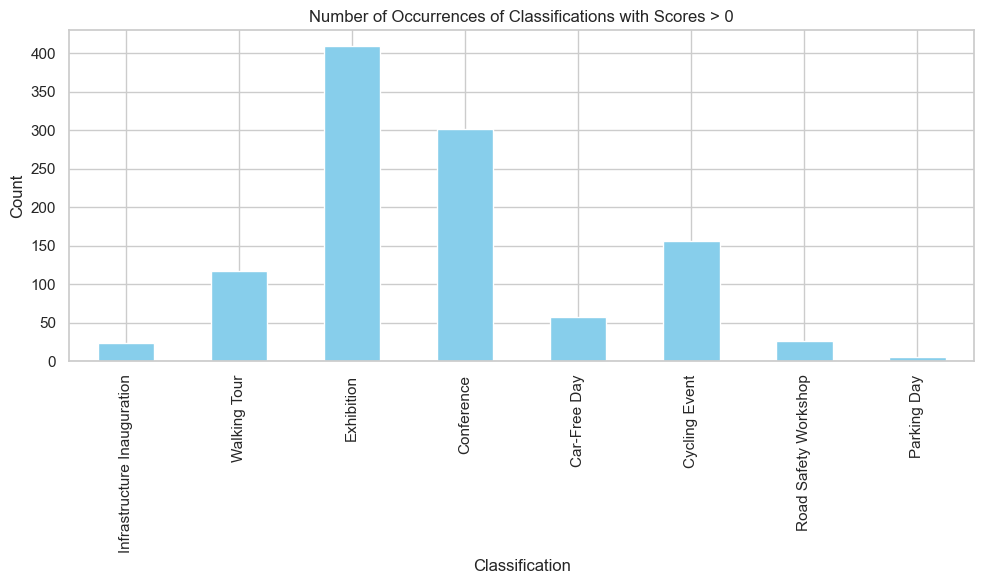

In [113]:
filtered_scores = scores_df > 0.3

# Count the occurrences of each classification with scores > 0.5
classification_counts = filtered_scores.sum()

# Plot the histogram
plt.figure(figsize=(10, 6))
classification_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Occurrences of Classifications with Scores > 0')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [80]:
pd.set_option('display.max_colwidth', None)

In [ ]:
df=pd.read_csv('activities_tc.csv')
display(df[df['primary_score']<0.4])

In [ ]:
pd.set_option('display.max_rows', 50)

In [ ]:
display(df[df['classification_to_plot']=='Other'])

In [160]:
import pandas as pd
from ipywidgets import Button, HBox, VBox, Label, Textarea, Checkbox, Output
from IPython.display import display
import nest_asyncio

df = pd.read_csv('activities_tc.csv')
sampled_df = df.groupby('primary_classification').apply(lambda x: x.sample(n=1, random_state=42) if len(x) >= 20 else x)
sampled_df = sampled_df.reset_index(drop=True)


output = Output() # Create an Output widget to capture print statements

categories = ['Cycling Event', 'Walking Tour', 'Road Safety Workshop', 'Car-Free Day', 'Parking Day', 'Exhibition', 'Infrastructure Inauguration']
checkboxes = [Checkbox(description=category) for category in categories]
label_name = Label(value="")
text_area_description = Textarea(value="", layout={'width': '1100px', 'height': '100px'}, disabled=True)

tagged_events = []
current_activity_index = 0  # Index for current activity

def update_activity():
    global current_activity_index
    if current_activity_index < len(sampled_df):
        row = sampled_df.iloc[current_activity_index]
        event_id = row['ID']
        name = row['activity_name']
        description = row['activity_description']
        initial_class = row['primary_classification']
        
        # Update the label, description and checkboxes
        label_name.value = f"Annotate (ID: {event_id}): {name} [{initial_class}]"
        text_area_description.value = description
        for checkbox in checkboxes:
            checkbox.value = False
    else:
        label_name.value = "All events tagged!"
        text_area_description.value = ""
        submit_button.disabled = True  # Disable the button after tagging all events

# Function to handle submit button click
def on_submit(button):
    global current_activity_index
    selected_labels = [c.description for c in checkboxes if c.value]
    event_id = sampled_df.iloc[current_activity_index]['ID']
    tagged_events.append((event_id, selected_labels)) 
    
    current_activity_index += 1
    update_activity()  

# Create a submit button
submit_button = Button(description="Submit") #Initialize button
submit_button.on_click(on_submit) #When clicked updates activity

update_activity() #Initialize for first activity
display(VBox([label_name, text_area_description, HBox(checkboxes), submit_button, output]))

# This block is necessary to allow asyncio to work with Jupyter notebooks
nest_asyncio.apply()

C:\Users\afontecha\AppData\Local\Temp\ipykernel_15448\3887005493.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('primary_classification').apply(lambda x: x.sample(n=1, random_state=42) if len(x) >= 20 else x)


In [163]:
classification_results = pd.DataFrame(columns=['ID'] + categories)

for event_id, labels in tagged_events:
    row = {'ID': event_id}
    for category in categories:
        row[category] = category in labels
    classification_results = pd.concat([classification_results, pd.DataFrame([row])], ignore_index=True)

classification_results.to_csv('classification_results.csv')
display(classification_results)

,ID,Cycling Event,Walking Tour,Road Safety Workshop,Car-Free Day,Parking Day,Exhibition,Infrastructure Inauguration
0,3,False,False,False,True,False,False,False
1,316,False,True,False,False,False,False,False
2,538,False,True,False,False,False,False,False
3,940,True,False,False,False,False,False,False
4,0,True,False,False,False,False,False,False
5,319,True,False,False,False,False,False,False
6,334,True,False,False,False,False,False,False
7,369,True,False,False,False,False,False,False
8,611,True,False,False,False,False,False,False
9,892,True,False,False,False,False,False,False


In [ ]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd

# Load your dataframe from the CSV file
df = pd.read_csv('activities_tc.csv')
df['city'] = df['city'].apply(lambda x: x.split(',')[0].strip())

# Define the SPARQL endpoint and the query
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

# Define the SPARQL query to fetch data about cities and municipalities in Spain
query = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>

# Retrieve distinct municipalities and cities in Spain
SELECT ?city ?cityLabel ?population ?loc WHERE {
  { 
    # Match cities in Spain
    ?city wdt:P31 wd:Q515 .         # Instance of a city
    ?city wdt:P17 wd:Q29 .          # Located in Spain
  } UNION {
    # Match municipalities in Spain
    ?city wdt:P31 wd:Q2074737 .     # Instance of a municipality
    ?city wdt:P17 wd:Q29 .          # Located in Spain
  }
  
  OPTIONAL { ?city wdt:P1082 ?population . }    # Get the population (optional)
  OPTIONAL { ?city wdt:P625 ?loc . }            # Get the location (optional)
  OPTIONAL { ?city rdfs:label ?cityLabel . }    # Get the label for the city/municipality
  
  FILTER (LANG(?cityLabel) = "es")              # Filter for Spanish labels
}
ORDER BY DESC(?population)
"""

# Set the query and request JSON results
sparql.setQuery(query)
sparql.setReturnFormat(JSON)

# Execute the query and fetch results
results = sparql.query().convert()

# Process the results into a list of dictionaries
cities_data = []
for result in results["results"]["bindings"]:
    city_info = {
        "city": result["city"]["value"],
        "cityLabel": result["cityLabel"]["value"] if "cityLabel" in result else None,
        "population": result["population"]["value"] if "population" in result else None,
        "loc": result["loc"]["value"] if "loc" in result else None
    }
    cities_data.append(city_info)

# Convert the list of dictionaries to a pandas DataFrame
df_sparql = pd.DataFrame(cities_data)
df['key'] = df.apply(lambda x: next((label for label in df_sparql['cityLabel'] if label in x['city']), None), axis=1)

# Merge using the 'key' column where the city contains the cityLabel
df_e = pd.merge(df, df_sparql, left_on="key", right_on="cityLabel", how="left")
# Print the number of matched rows (rows where there is non-null data from SPARQL results)
matched_rows = df_e[df_e['cityLabel'].notnull()]
unique_city_count = matched_rows['cityLabel'].nunique()
print(f"Number of matched cities: {unique_city_count}")

# Print the resulting dataframe


In [180]:
import pandas as pd

# Load the merged DataFrame
merged_df = pd.read_csv('activities_tce.csv')

# Ensure you have a column for latitude (adjust the column name if needed)
# For example, let's assume the latitude column is named 'latitude'

# Convert the latitude column to numeric, if it's not already
merged_df['latitude'] = pd.to_numeric(merged_df['latitude'], errors='coerce')

# Sort the DataFrame by latitude in descending order and get the top 10 activities
top_northern_activities = merged_df.nlargest(10, 'latitude')

# Display the results
print("Top 10 Northern Activities:")
display(top_northern_activities[['city', 'activity_name', 'latitude','longitude']])


Top 10 Northern Activities:


,city,activity_name,latitude,longitude
927,"Torre-Serona, Spain",Caminada pels carres i camins del municipi,50.838926,4.384220
928,"Torrebesses, Spain",Ruta cicloturística guiada,50.838926,4.384220
929,"Torrebesses, Spain",Caminada verda,50.838926,4.384220
175,"Burela, Spain",Andando al colegio,43.660295,-7.361109
176,"Burela, Spain",Paseo saludable,43.660295,-7.361109
177,"Burela, Spain",Charlas con Stop Accidentes,43.660295,-7.361109
178,"Burela, Spain",Ruta en bici y circuito de habilidad,43.660295,-7.361109
391,"Gijón, Spain",Paseos en bicicletas adaptdas para personas con movilidad reducida,43.532201,-5.661119
392,"Gijón, Spain",Talleres de revisión de bicicletas (ITBicis),43.532201,-5.661119
393,"Gijón, Spain",Biciescuela Adulta. Nivel 1: Cursos para aprender a montar en bicicleta,43.532201,-5.661119


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.cm as cm
import numpy as np

def parse_point(point_str):
    # Check if the point_str is valid (not NaN or empty)
    if isinstance(point_str, str) and point_str.startswith("Point("):
        # Extract latitude and longitude from the Point(a b) format
        point_str = point_str.replace("Point(", "").replace(")", "")
        lon, lat = map(float, point_str.split())
        return Point(lon, lat)
    else:
        return None  # Return None for invalid entries

# Assuming df_e is already defined and contains your data
df_e['geometry'] = df_e['loc'].apply(parse_point)
df_e = df_e[df_e['geometry'].notna()]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_e, geometry='geometry')

# Step 2: Group by city and count activities
activity_count = gdf.groupby('city_x').size().reset_index(name='count')

# Step 3: Merge the activity counts with the original GeoDataFrame
gdf_counts = gdf.merge(activity_count, on='city_x')

# Create a GeoDataFrame for plotting
gdf_counts = gpd.GeoDataFrame(gdf_counts, geometry='geometry')

# Step 4: Plot the bubble map
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the base map
gdf_counts = gdf_counts.set_crs(epsg=4326)  # Set original CRS
gdf_counts = gdf_counts.to_crs(epsg=3857)   # Convert to Web Mercator

# Normalize the counts for colormap
norm = plt.Normalize(gdf_counts['count'].min(), gdf_counts['count'].max())
colors = cm.viridis(norm(gdf_counts['count']))  # You can choose any colormap

# Create a scatter plot for activities
scatter = gdf_counts.plot(ax=ax, marker='o', color=colors, markersize=gdf_counts['count'] * 20, alpha=0.5)

# Add the basemap
ctx.add_basemap(ax, crs=gdf_counts.crs.to_string())

# Set titles and labels
ax.set_title('Activity Count per City')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Optional: Add a color bar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Activity Count')

plt.grid()

# Show the plot
plt.show()


In [ ]:
df=pd.read_csv('activities_tc.csv')
df_unique_cities = pd.read_csv('activities.csv').drop(['activity_name', 'activity_description', 'ID','Unnamed: 0'], axis=1)
df_unique_cities = df_unique_cities.drop_duplicates()
merged_df = pd.merge(df, df_unique_cities, on='city', how='inner')
display(merged_df)
merged_df.to_csv('activities_tce.csv')

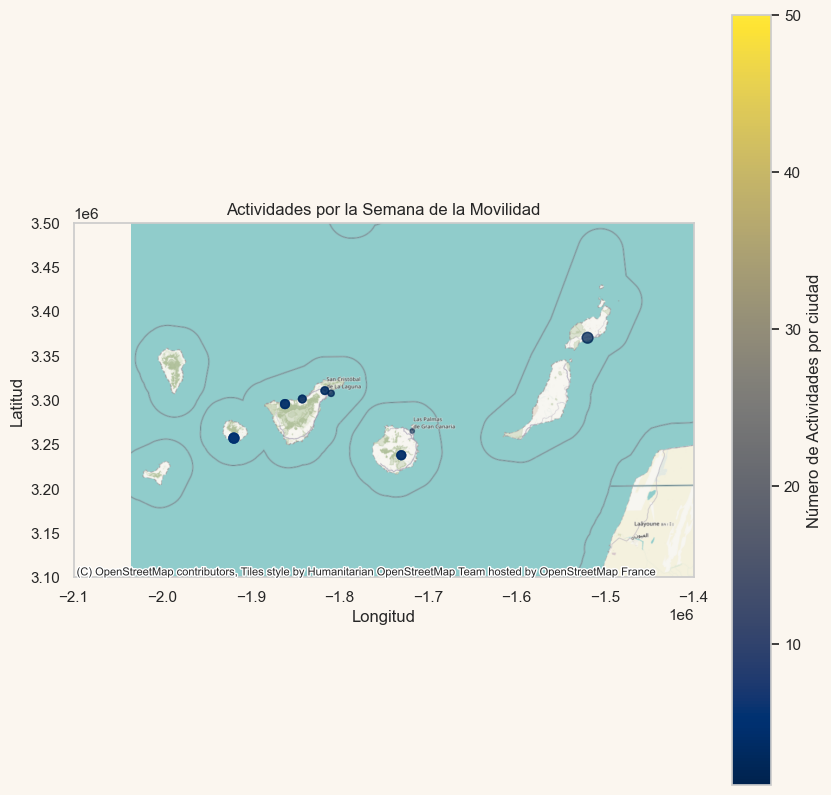

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
from matplotlib import cm
import numpy as np

# Assuming merged_df contains the merged city data
# Ensure that the merged_df has the necessary latitude, longitude, and city columns
merged_df=pd.read_csv('activities_tce.csv')
# Step 1: Create a GeoDataFrame from merged_df, with geometry from latitude/longitude
merged_df['geometry'] = merged_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
ids_to_drop = [927, 928, 929]
merged_df = merged_df[~merged_df['ID'].isin(ids_to_drop)]
gdf = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Step 2: Group by city and count activities
activity_count = gdf.groupby('city').size().reset_index(name='count')

# Step 3: Merge the activity counts with the original GeoDataFrame
gdf_counts = gdf.merge(activity_count, on='city')

# Step 4: Set the CRS and plot the bubble map
gdf_counts = gdf_counts.set_crs(epsg=4326)  # Set CRS to WGS84 (lat/lon)
gdf_counts = gdf_counts.to_crs(epsg=3857)   # Convert to Web Mercator for plotting

# Normalize the counts for colormap
norm = plt.Normalize(gdf_counts['count'].min(), gdf_counts['count'].max())
colors = cm.cividis(norm(gdf_counts['count']))  # Choose any colormap

# Plot the bubble map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the cities with bubbles sized according to activity count
gdf_counts.plot(ax=ax, marker='o', color=colors, markersize=gdf_counts['count'] * 10, alpha=0.5)

# Add the basemap using contextily


provider = ctx.providers.Stadia.StamenWatercolor(api_key="77d36c7f-e444-4059-8428-d6f603315297")

# Update the provider URL to include your API key
provider["url"] = provider["url"] + "?api_key={api_key}"
provider = ctx.providers.OpenStreetMap.HOT
ctx.add_basemap(ax, crs=gdf_counts.crs.to_string(), source=provider, zoom=8)

# Set titles and labels
ax.set_title('Actividades por la Semana de la Movilidad')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
ax.set_facecolor('#fbf6ef') 

ax.set_xlim([-2.1e6, -1.4e6])
ax.set_ylim([3.1e6, 3.5e6])
# Optional: Add a color bar for activity count
sm = plt.cm.ScalarMappable(cmap=cm.cividis, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Número de Actividades por ciudad')

plt.grid()

# Show the plot
plt.show()

C:\Users\afontecha\AppData\Local\Temp\ipykernel_15448\2423030138.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette="cividis_r", ax=ax)


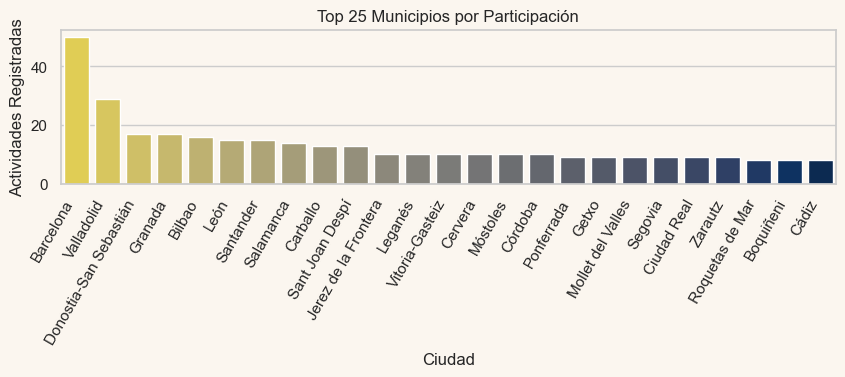

In [65]:
def plot_top_cities(df, top_n=20):
    city_counts = df['city'].value_counts().nlargest(top_n)
    
    # Create the figure and axes objects
    fig, ax = plt.subplots(figsize=(10, 2))
    
    # Create the bar plot
    sns.barplot(x=city_counts.index, y=city_counts.values, palette="cividis_r", ax=ax)
    
    # Set the background color for the figure and axes
    fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
    ax.set_facecolor('#fbf6ef')  # Background of the axes
    
    # Customize the plot
    plt.title(f"Top {top_n} Municipios por Participación")
    plt.xlabel("Ciudad")
    plt.ylabel("Actividades Registradas")
    plt.xticks(rotation=60, ha='right')
    
    # Show the plot
    plt.show()

df = pd.read_csv('activities_tce.csv')
df['city'] = df['city'].apply(lambda x: x.split('(')[0].split(',')[0].strip())
plot_top_cities(df,25)

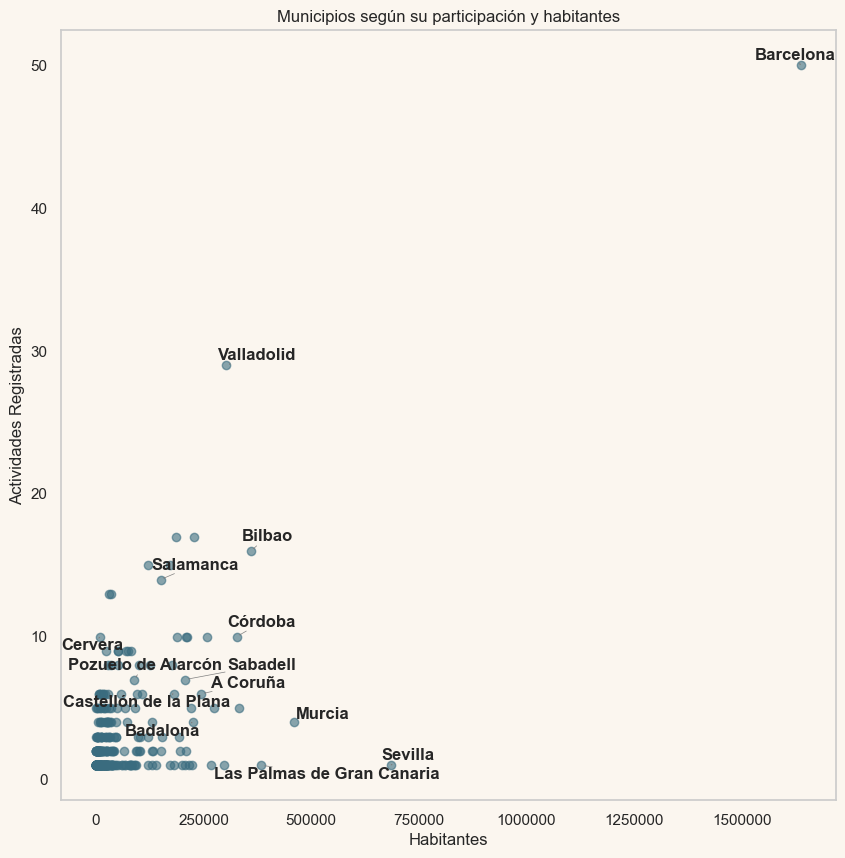

In [39]:

def scatter_plot(df):
    df=df[df['city'] != 'Villena']
    city_activity_counts = df.groupby('city').agg(
        activity_count=('classification_to_plot', 'size'),  # Count activities
        max_population=('population', 'max')  # Get maximum population
    ).reset_index()

    # Step 2: Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Create the scatter plot
    ax.scatter(city_activity_counts['max_population'], city_activity_counts['activity_count'], color='#3a6c7f', alpha=0.6)
    

    plt.title('Municipios según su participación y habitantes')
    plt.xlabel('Habitantes')
    plt.ylabel('Actividades Registradas')
    
    fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
    ax.set_facecolor('#fbf6ef')  # Background of the axes
    ax.xaxis.get_major_formatter().set_scientific(False)
    texts=[]
    radius=60000
    coords = city_activity_counts[['max_population', 'activity_count']].values
    
    for i in range(len(city_activity_counts)):
        # Get the same activity count for the current city
        current_activity_count = city_activity_counts['activity_count'].iloc[i]
        
        # Filter cities with the same activity count
        same_count_indices = city_activity_counts[city_activity_counts['activity_count'] == current_activity_count].index
        
        # Check if the x-distance from the current point to other points with the same activity count is greater than the threshold
        if all(abs(coords[i][0] - coords[j][0]) > radius for j in same_count_indices if j != i):
        
            texts.append(ax.annotate(city_activity_counts['city'].iloc[i], 
                                  (city_activity_counts['max_population'].iloc[i], city_activity_counts['activity_count'].iloc[i]),
                                  ha='center',
                                  fontweight='bold'))

    # Use adjustText to prevent overlap of labels
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
    plt.grid()
    plt.show()
    
df['classification_to_plot'] = df.apply(
    lambda row: (
        'Other' if row['primary_score'] <= THRESHOLD else
        row['primary_classification'] #if pd.isna(row['secondary_classification']) else
        #f"{row['primary_classification']} - Other" if row['secondary_score'] <= THRESHOLD else
        #f"{row['primary_classification']} - {row['secondary_classification']}"
    ),
    axis=1
)
scatter_plot(df)

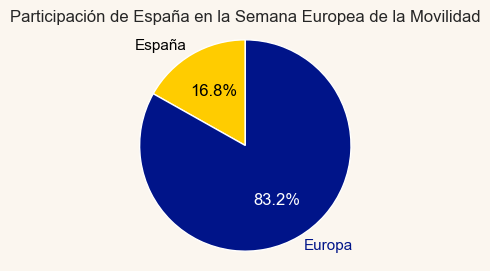

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Participation data
spain_cities = 466
total_cities = 2766

# Data for the pie chart
sizes = [spain_cities, total_cities - spain_cities]
labels = ['España', 'Europa']
colors = ['#FFCC00', '#001489']  # Yellow for Spain, gray for others

# Create the pie chart
fig, ax = plt.subplots(figsize=(3, 3))  # Create a figure and axes
wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

# Set the background colors
fig.patch.set_facecolor('#fbf6ef')  # Background of the figure
ax.set_facecolor('#fbf6ef')  # Background of the axes

# Set colors for the text
texts[0].set_color('black')  # Color for España
texts[1].set_color('#001489')  # Color for Europa

# Set colors for the percentage texts
autotexts[0].set_color('black')  # Percentage for España
autotexts[1].set_color('white')  # Percentage for Europa

# Final adjustments
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title(f'Participación de España en la Semana Europea de la Movilidad')
plt.show()


C:\Users\afontecha\AppData\Local\Temp\ipykernel_15448\3997873189.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


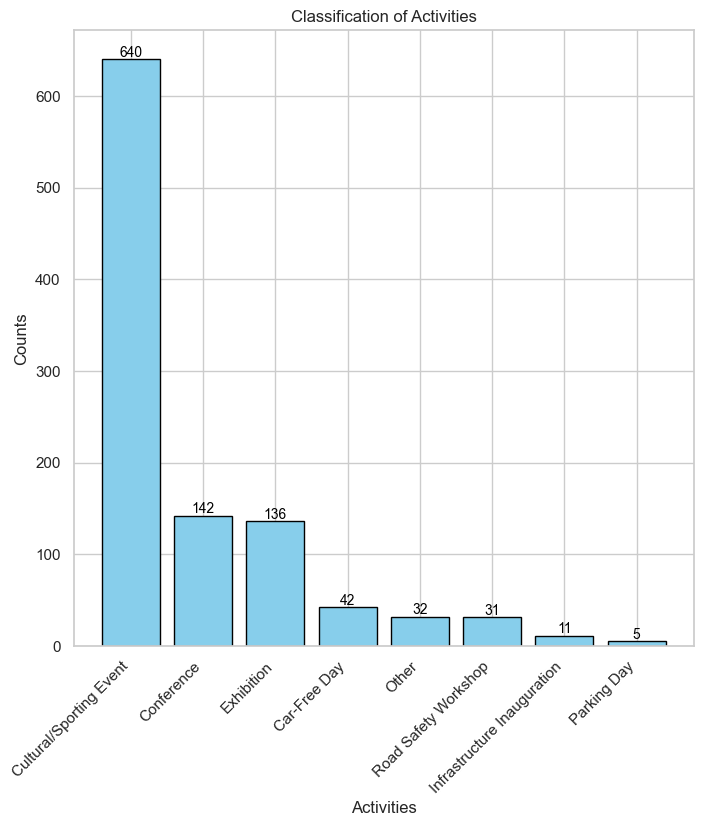

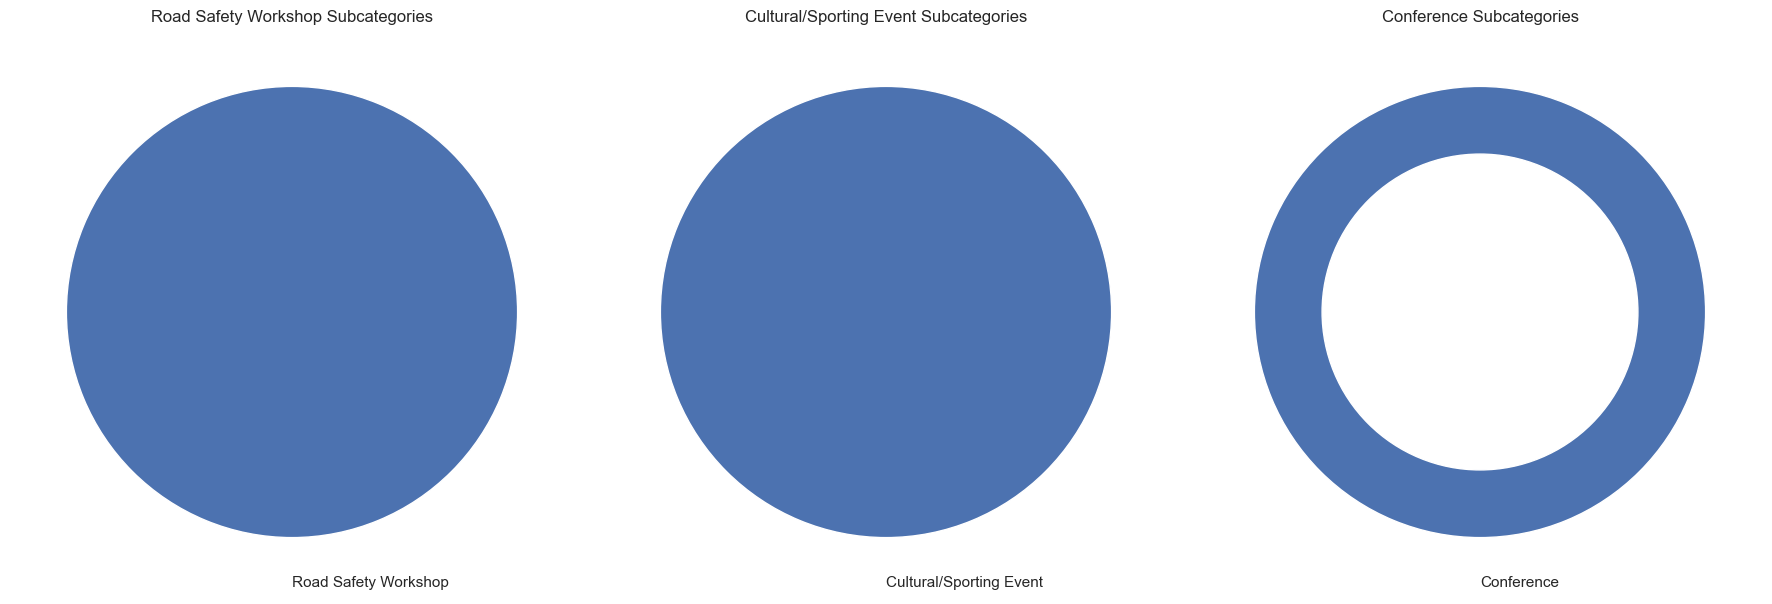

C:\Users\afontecha\AppData\Local\Temp\ipykernel_15448\3997873189.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_counts.index, y=city_counts.values, palette="viridis")


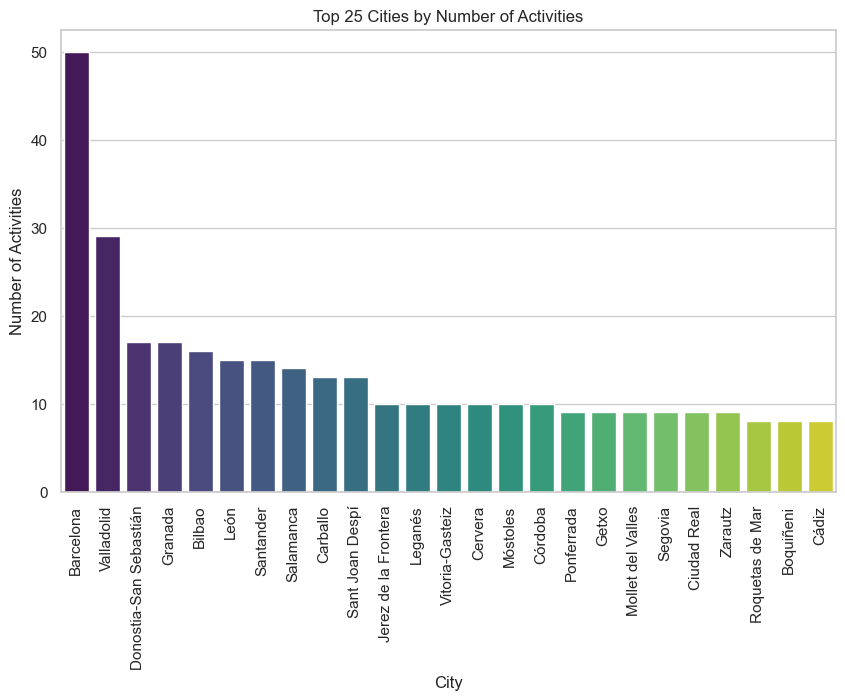

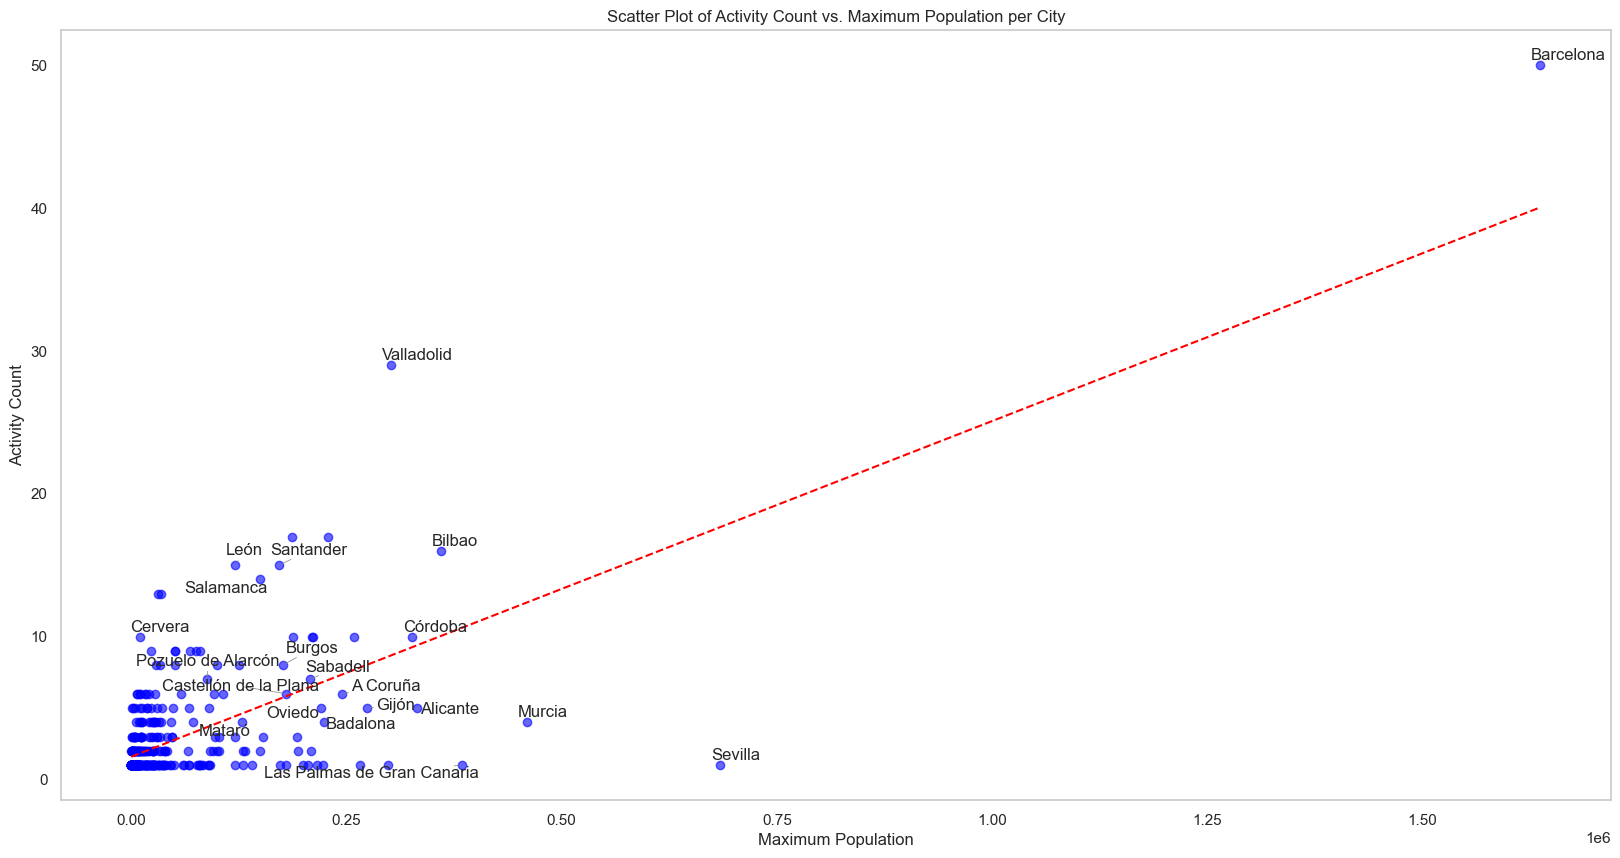

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from adjustText import adjust_text

sns.set(style="whitegrid")
THRESHOLD = 0.30

# Create classification data
df['classification_to_plot'] = df.apply(
    lambda row: (
        'Other' if row['primary_score'] <= THRESHOLD else
        row['primary_classification'] #if pd.isna(row['secondary_classification']) else
        #f"{row['primary_classification']} - Other" if row['secondary_score'] <= THRESHOLD else
        #f"{row['primary_classification']} - {row['secondary_classification']}"
    ),
    axis=1
)

df['city'] = df['city'].apply(lambda x: x.split('(')[0].split(',')[0].strip())

def create_donut_chart(sizes, labels, title, ax):
    wedges, texts = ax.pie(
        sizes,
        labels=labels,
        startangle=90,
        counterclock=False,
        wedgeprops=dict(width=0.3)
    ) if len(labels) > 1 else ax.pie(sizes, labels=labels, startangle=90, counterclock=False)

    ax.set(aspect="equal")
    ax.set_title(title)

    # Draw circle for donut effect
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)

    # Adjust position and orientation of labels
    for i, text in enumerate(texts):
        angle = (wedges[i].theta1 + wedges[i].theta2) / 2  # Calculate the angle of the wedge
        radius = 1.2  # Adjust this for distance from the center
        # Set the position of the label based on the angle
        x = radius * np.cos(np.radians(angle))
        y = radius * np.sin(np.radians(angle))
        text.set_position((x, y))  # Set new position



def create_bar_chart(sizes, labels, title, ax):
    bars = ax.bar(labels, sizes, color='skyblue', edgecolor='black')
    ax.set(title=title, xlabel='Activities', ylabel='Counts')
    ax.set_xticklabels(labels, rotation=45, ha='right')

    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')



def plot_classifications(df):
    counts = df['classification_to_plot'].value_counts()
    fig, ax = plt.subplots(figsize=(8, 8))
    create_bar_chart(counts.values, counts.index, 'Classification of Activities', ax)
    plt.show()


def plot_subcategories(df):
    categories = ['Road Safety Workshop', 'Cultural/Sporting Event', 'Conference']
    titles = ['Road Safety Workshop Subcategories', 'Cultural/Sporting Event Subcategories', 'Conference Subcategories']
    fig, axes = plt.subplots(1, len(categories), figsize=(18, 6))  # Create subplots

    for ax, category, title in zip(axes, categories, titles):
        filtered_df = df[df['classification_to_plot'].str.startswith(category)]
        counts = filtered_df['classification_to_plot'].value_counts()
        create_donut_chart(counts.values, counts.index, title, ax)
    
    plt.tight_layout()  # Adjust layout
    plt.show()

# Example usage
plot_classifications(df)
plot_subcategories(df)



In [36]:
df=pd.read_csv('activities_tc.csv')
THRESHOLD=0.5
df['classification_to_plot'] = df.apply(
    lambda row: (
        'Other' if row['primary_score'] <= THRESHOLD else
        row['primary_classification'] if pd.isna(row['secondary_classification']) else
        f"{row['primary_classification']} - Other" if row['secondary_score'] <= THRESHOLD else
        f"{row['primary_classification']} - {row['secondary_classification']}"
    ),
    axis=1
)
df[df['classification_to_plot'].str.startswith('Conference - Pr')]

,ID,city,activity_name,activity_description,primary_classification,primary_score,secondary_classification,secondary_score,classification_to_plot
4,4,"A Coruña, Spain",La policía local con la movilidad,Una muestra de las diversas actividades que re...,Conference,0.762723,Professionals/Policymakers,0.535225,Conference - Professionals/Policymakers
287,287,"Córdoba, Spain",Jornadas profesionales Arquitectos y Urbanista...,Descripción:\r\nCharla sobre diseño urbano sos...,Conference,0.631896,Professionals/Policymakers,0.510138,Conference - Professionals/Policymakers
288,288,"Córdoba, Spain",Jornadas Legalidad y Nuevos Seguros para Vehíc...,Descripción:\r\nCharla sobre legislación y seg...,Conference,0.760423,Professionals/Policymakers,0.608293,Conference - Professionals/Policymakers
290,290,"Córdoba, Spain",Jornada Vicerrectorado de Transferencia: Proye...,Presentación y discusión de proyectos innovado...,Conference,0.564113,Professionals/Policymakers,0.758482,Conference - Professionals/Policymakers
378,378,"Gavà, Spain",Taller de capacidad viaria,Martes 17 tendrá lugar taller de capacidad via...,Conference,0.579285,Professionals/Policymakers,0.516560,Conference - Professionals/Policymakers
712,712,"Reus, Spain",INSTITUT GABRIEL FERRATER Xerrada informativa ...,Xerrada informativa a l’Institut Gabriel Ferra...,Conference,0.532374,Professionals/Policymakers,0.516655,Conference - Professionals/Policymakers
785,785,"San Cristóbal de La Laguna, Spain",Conquistando el Espacio Público,Se realizará una charla dirigida a los Comités...,Conference,0.737208,Professionals/Policymakers,0.898796,Conference - Professionals/Policymakers
846,846,"Santa Cruz de Tenerife, Spain",TECHNICAL CONFERENCE: Technology and Innovatio...,"THURSDAY, September 19, 2024\r\nSESSION 1: Cha...",Conference,0.676542,Professionals/Policymakers,0.764920,Conference - Professionals/Policymakers


In [136]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

#nltk.download('stopwords')

english_stop_words = stopwords.words('english')
catalan_stop_words = stopwords.words('catalan')
spanish_stop_words = stopwords.words('spanish')
custom_filter=['available','description']
# Load the DataFrame (replace with your actual file)
df = pd.read_csv('activities_tc.csv')

# Fill any NaN values with empty strings to avoid errors
df['activity_name'] = df['activity_name'].fillna('')
df['activity_description'] = df['activity_description'].fillna('')

# Combine the 'name' and 'description' into a single text column
df['combined_text'] = df['activity_name'] + ' ' + df['activity_description']

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=spanish_stop_words+catalan_stop_words+english_stop_words+custom_filter, max_features=20)  # limit to 20 most relevant terms

# Fit the vectorizer to the combined text column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

# Get the feature names (i.e., terms)
terms = tfidf_vectorizer.get_feature_names_out()

# Sum the TF-IDF scores across all documents (rows) to get overall term importance
sum_tfidf_scores = tfidf_matrix.sum(axis=0)

# Create a DataFrame of terms and their corresponding TF-IDF scores
tfidf_scores_df = pd.DataFrame({'term': terms, 'score': sum_tfidf_scores.tolist()[0]})

# Sort the terms by their score in descending order to see the most important terms
tfidf_scores_df = tfidf_scores_df.sort_values(by='score', ascending=False)

# Display the most relevant terms
print(tfidf_scores_df)


          term       score
3    bicicleta  106.881001
10   movilidad   90.122907
15  sostenible   75.278841
9    mobilitat   70.768082
5     caminada   62.465657
0           00   62.324013
2         bici   60.070546
16      taller   50.425377
8       escola   47.109251
13     popular   45.804184
1           30   42.371328
14        ruta   41.941511
4   bicicletas   37.889043
6       ciudad   37.607664
19        vial   36.827396
7          día   35.774073
12    pedalada   35.014579
17  transporte   34.175262
11      parque   30.963447
18         uso   28.454574


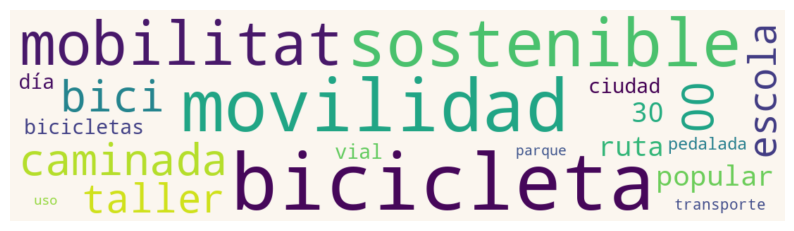

In [154]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

sum_tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Use .A1 to convert to a 1D array

# Create a dictionary of terms and their scores
term_score_dict = dict(zip(terms, sum_tfidf_scores))

# Generate a word cloud
wordcloud = WordCloud(width=1100, height=300, background_color='#fbf6ef',
                      
    margin=20,                # Increase the margin around words
    contour_color='black',     # Add a contour color
    contour_width=1,          # Set contour width
    scale=1  ,
                       colormap='viridis'       ).generate_from_frequencies(term_score_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()
